In [1]:
import torch
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from scipy import ndimage as ndi
from pycocotools.coco import COCO
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
import skimage as ski
# load Mask2Former fine-tuned on COCO instance segmentation
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip
!pip install pycocotools

--2025-05-13 12:07:49--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.114.27, 16.15.184.230, 3.5.25.44, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.114.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.3MB/s    in 2.5s    

2025-05-13 12:07:51 (96.3 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [2]:
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-coco-instance")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-coco-instance")
def Mask2Former_Segmentation(image):
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
    result = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    predicted_instance_map = result["segmentation"]

    return predicted_instance_map.cpu().numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/79.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

In [3]:
def clustering_segmentation(image, k=3):
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape(image.shape)

    return segmented_img

In [4]:
def global_threshold_segmentation(image, thresh_value=127, max_value=255):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, thresh_value, max_value, cv2.THRESH_BINARY)
    return binary

In [5]:
def GetImage():
    coco = COCO("annotations/instances_val2017.json")
    catIds = coco.getCatIds(catNms=['cat'])
    imgIds = coco.getImgIds(catIds=catIds)
    img_info = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
    img_url = img_info['coco_url']
    response = requests.get(img_url)
    image = Image.open(BytesIO(response.content))
    return image

In [9]:
def Edge_based_segmentation(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  edges = ski.feature.canny(gray)
  Filled = ndi.binary_fill_holes(edges)
  return Filled

In [6]:
def compare_segmentation_methods(image,mask2former_result,clustering_result,global_thresh_result,edge_based_result):
    # Convert results to consistent format for display
    mask2former_display = mask2former_result
    clustering_display = clustering_result
    global_thresh_display = np.stack([global_thresh_result]*3, axis=-1)  # Convert to 3-channel
    edge_based_display = np.stack([edge_based_result.astype(np.uint8)*255]*3, axis=-1)  # Convert to 3-channel

    # Create figure
    plt.figure(figsize=(20, 10))

    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Mask2Former
    plt.subplot(2, 3, 2)
    plt.imshow(mask2former_display)
    plt.title('Mask2Former Segmentation')
    plt.axis('off')

    # Clustering
    plt.subplot(2, 3, 3)
    plt.imshow(clustering_display)
    plt.title('Clustering')
    plt.axis('off')

    # Global Threshold
    plt.subplot(2, 3, 4)
    plt.imshow(global_thresh_display)
    plt.title('Global Threshold')
    plt.axis('off')

    # Edge-based
    plt.subplot(2, 3, 5)
    plt.imshow(edge_based_display)
    plt.title('Edge-based Segmentation')
    plt.axis('off')

    # Show all results
    plt.tight_layout()
    plt.show()

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


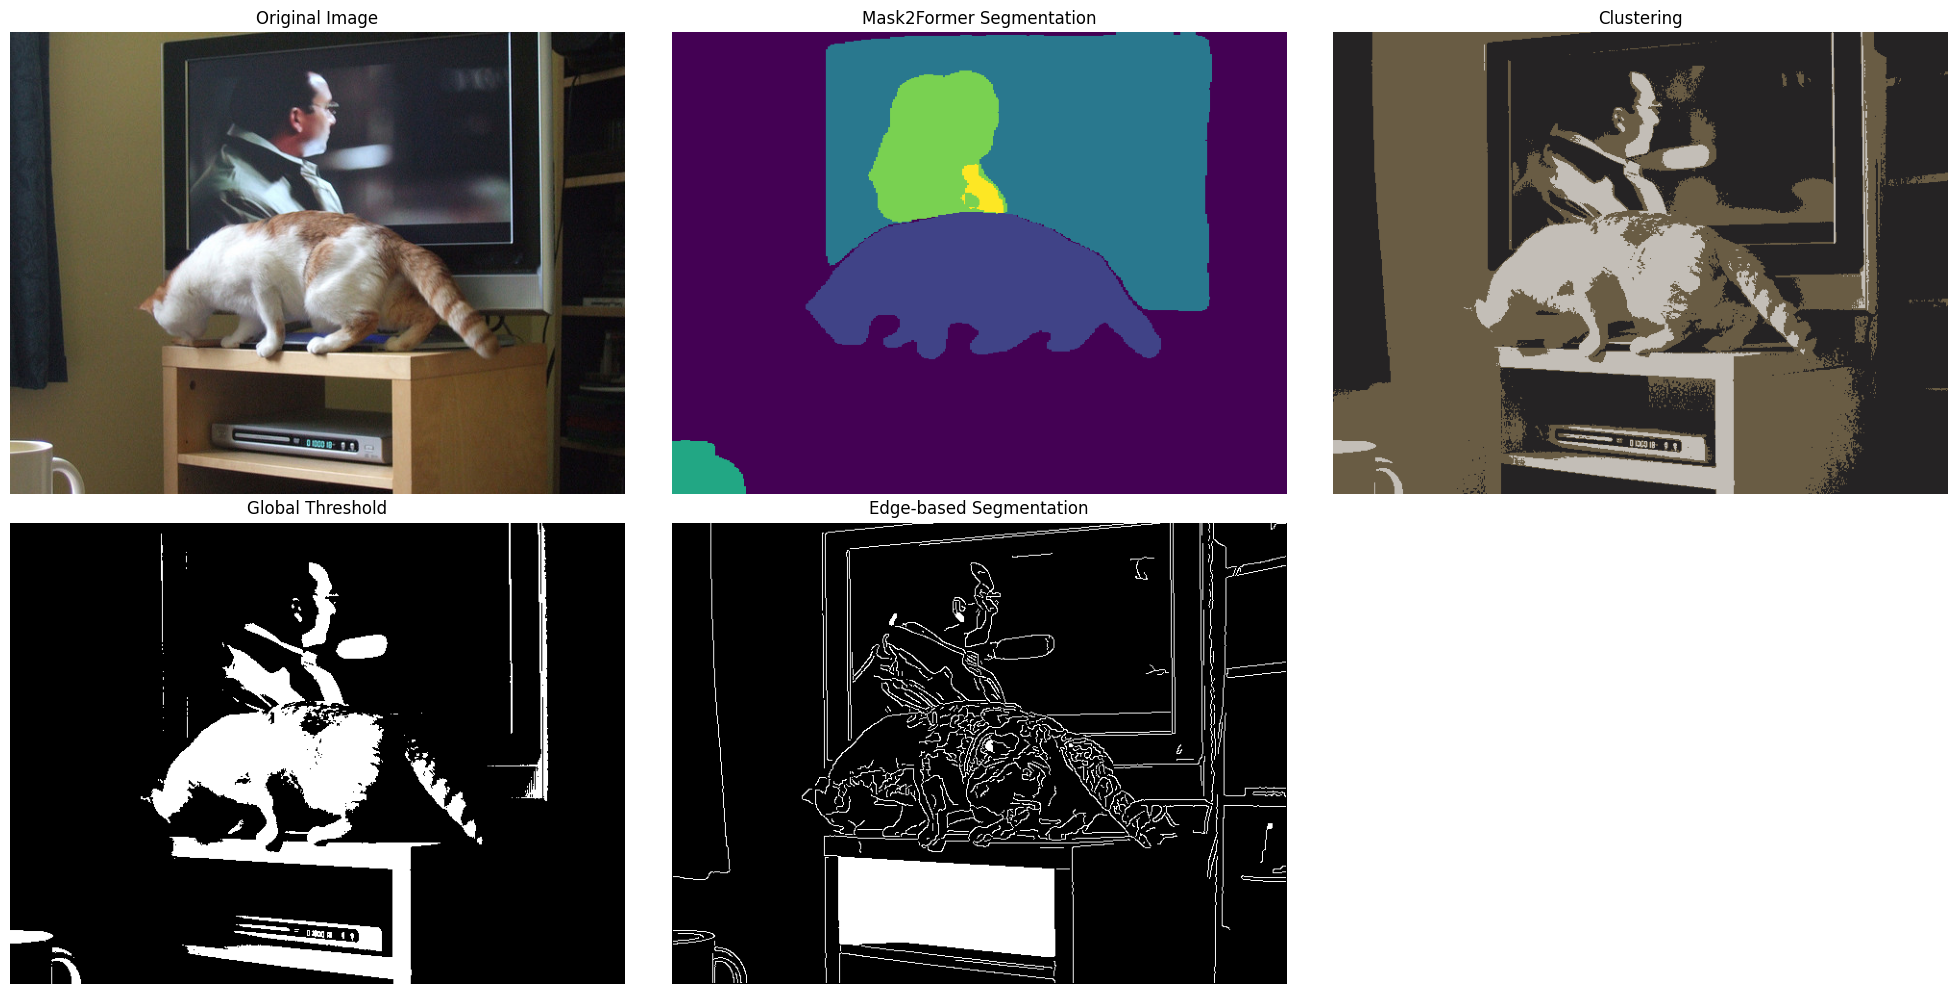

In [18]:
# Get an image using your existing function
image=GetImage()
# Compare segmentation methods
compare_segmentation_methods(image,Mask2Former_Segmentation(image),clustering_segmentation(np.array(image)),global_threshold_segmentation(np.array(image)),Edge_based_segmentation(np.array(image)))